<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 38px; color: black; font-weight: bold;">
Latent Neural SDE Toy VAE example - Copy/Paste https://github.com/google-research/torchsde/blob/master/examples/latent_sde.py
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Set Up
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchsde
# from torchdiffeq import odeint, odeint_adjoint

# from mpl_toolkits.mplot3d import Axes3D
import timeit
from tqdm import tqdm
import torchviz

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Data and Problem Statement
</div>

- We observe a deterministic function with Gaussian noise

In [4]:
LENGTH = 20 # total number of points used to generate the data

In [5]:
def f(x):
    """Data generating funtion"""
    y = torch.sin(x * 8 * torch.pi)
    return y

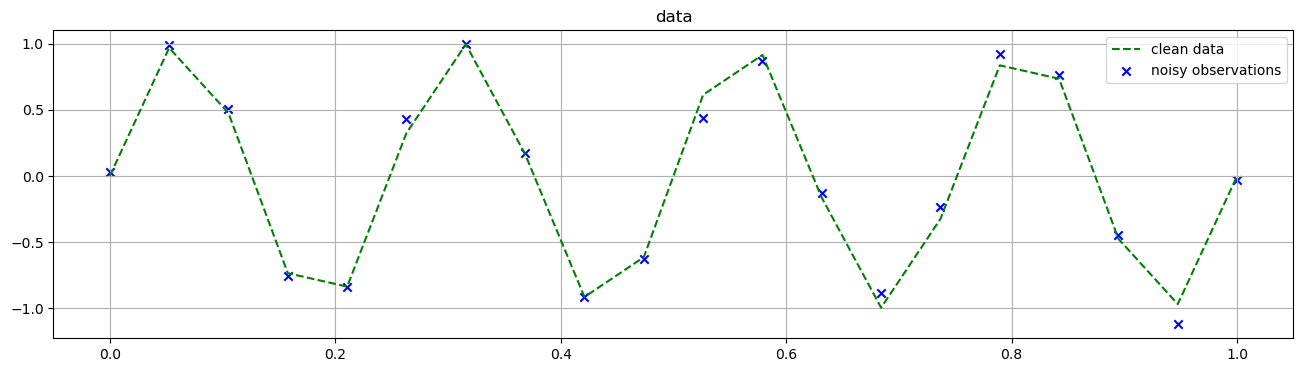

In [6]:
t_start = 0.0
t_end = 1.0
times = torch.linspace(t_start, t_end, LENGTH).to(device)
x_ = f(times)
sigma = torch.tensor(0.1).to(device)
x = x_ + torch.randn((LENGTH,)).to(device) * sigma

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
ax.plot(times.detach().cpu(), x_.detach().cpu(), label='clean data', color='green', ls='--' )
ax.scatter(times.detach().cpu(), x.detach().cpu(), label='noisy observations', marker='x', color='blue')
ax.grid(True)
ax.legend()
ax.set_title(f'data')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model
</div>

In [7]:
# dimension of the observation space... 1 for now !
Dx = 1
# dimension of the latent space
Dz = 1

In [8]:
class BothSDE(nn.Module):
    """
    Class to implement both a prior and a posterior SDE.
    The code is deeply inspired from the GR Github,
    in an attempt to make this thing work at last.
    The latent space has dimension 1 here
    """
    
    def __init__(self, theta=1.0, mu=1.0, sigma=0.5, mup=10.0, hidden_dim=512):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.hidden_dim = hidden_dim
        
        # prior : the prior is an O.U. process
        # prior drift
        self.register_buffer("theta", torch.tensor([[theta]])) # trick : creates a tensor with value theta, shape (1,1)
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))
        # prior initial value z0
        logvar = np.log(sigma**2)
        self.register_buffer("pz0_mean", torch.tensor([[mu]]))
        self.register_buffer("pz0_logvar", torch.tensor([[logvar]]))
        
        # posterior : the posterior has a drift that is learnable
        # and the same diffusion -fixed- as the prior
        self.net = nn.Sequential(
            nn.Linear(3,self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim,1)
        )
        # posterior distribution initial value
        self.qz0_mean = nn.Parameter(torch.tensor([[mup]]), requires_grad=True)
        self.qz0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)
        
    def f(self,t,z):
        """
        Posterior drift.
        Inputs :
        - t (tensor) : time(s).
        - z (tensor) : latent variable(s).
        Outputs :
        - drift (tensor)
        Shapes:
        - during sdeint : 
            - t has shape (), and t.dim()==0
            - z has shape (batch_size=K, state_size=Dz=1)
            - drift has shape (batch_size=K, state_size=Dz=1)
        """
        # print(f"Drift method inputs : t {t.shape}, z {z.shape}")
        # manage different possible shapes of t
        if t.dim()==0:
            t = torch.full_like(z, fill_value=t)  # create a tensor t same shape as input z
        # here we use the positional encoding of the Github, not a LSTM
        # this is a positionning that is similar to the one in transformers
        z_ext = torch.cat([torch.sin(t), torch.cos(t), z], dim=-1)
        output = self.net(z_ext)
        # print(f"Drift method output : {output.shape}")
        return output
    
    def h(self,t,z):
        """
        Prior drift O.U.
        """
        return self.theta * (self.mu - z)
    
    def g(self,t,z):
        """
        shared diffusion, between prior and posterior.
        It is a constant here.
        Input z : tensor
        Output :
        - diffusion (tensor)
        Shapes:
        - during sdeint : 
            - t has shape (), and t.dim()==0 - Unused
            - z has shape (batch_size=K, state_size=Dz=1)
            - diffusion has shape (batch_size=K, state_size=Dz=1)
        """
        # print(f"Diffusion method inputs : t {t.shape}, z {z.shape}")
        output = self.sigma.repeat(z.size(0),1)
        # print(f"Diffusion method output : {output.shape}")
        return output # match z size
    
    def __repr__(self):
        desc = f"Object SDEs"
        desc += f"\nPRIOR:\n"
        desc += f"\tInitial value : pz0_mean : {self.pz0_mean}, pz0_logvar : {self.pz0_logvar}"
        desc += f"\n\tO.U. Process : theta : {self.theta}, mu : {self.mu}, sigma : {self.sigma}"
        desc += f"\nPOSTERIOR:\n"
        desc += f"\tInitial value (current params): qz0_mean : {self.qz0_mean}, qz0_logvar: {self.qz0_logvar}"
        desc += f"\n\tProcess - drift network : {self.net}"
        return desc

In [9]:
model = BothSDE().to(device)
print(model)

Object SDEs
PRIOR:
	Initial value : pz0_mean : tensor([[1.]], device='cuda:0'), pz0_logvar : tensor([[-1.3863]], device='cuda:0')
	O.U. Process : theta : tensor([[1.]], device='cuda:0'), mu : tensor([[1.]], device='cuda:0'), sigma : tensor([[0.5000]], device='cuda:0')
POSTERIOR:
	Initial value (current params): qz0_mean : Parameter containing:
tensor([[10.]], device='cuda:0', requires_grad=True), qz0_logvar: Parameter containing:
tensor([[-1.3863]], device='cuda:0', requires_grad=True)
	Process - drift network : Sequential(
  (0): Linear(in_features=3, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=1, bias=True)
)


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Pipeline
</div>

In [10]:
K = 10 # batch_size for SDE computation

In [11]:
# instantiate initial value prior and posterior distributions
pz0 = torch.distributions.Normal(loc=model.pz0_mean, scale=torch.exp(0.5*model.pz0_logvar))
qz0 = torch.distributions.Normal(loc=model.qz0_mean, scale=torch.exp(0.5*model.qz0_logvar))
# KL between pz0, qz0
kl0 = torch.distributions.kl_divergence(pz0,qz0).sum(dim=1) # shape (1,1) => (1)

# sample posterior z0s
# z0s = qz0.rsample((K,)).squeeze(-1).to(device)
z0s = (model.qz0_mean + torch.exp(0.5*model.qz0_logvar) * torch.randn((1,1)).to(device)).repeat(K,1)
# sample paths
# zs (L,K,1), kl_path (L-1,K)
zs, kl_path = torchsde.sdeint(model, z0s, times, method="euler", logqp=True)

# KL paths
kl_path = kl_path.mean(dim=1).sum() # shape ()

# Likelihood
# we assume a Gaussian likelihood on sampled zs
# batch_shape (L,K), event_shape ()
likelihood = torch.distributions.Normal(loc=zs.squeeze(-1), scale=0.05) 
logprob = likelihood.log_prob(x.unsqueeze(-1)) # (L,K)
logprob = logprob.mean(dim=-1).sum() # shape ()

# total loss
loss = kl0 + kl_path - logprob

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Training
</div>

In [12]:
N_EPOCHS = 3

model = BothSDE().to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

In [14]:
def check_gradient_flow(model):
    """Check gradient flow for all parameters"""
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"{name}: grad_norm = {grad_norm:.6f}")
            else:
                print(f"{name}: NO GRADIENT")
        else:
            print(f"{name}: requires_grad = False")

In [ ]:
losses = []
kl0s = []
kl_paths = []
likelihoods = []

for epoch in range(N_EPOCHS):
    
    # training mode
    model.train()
    
    # instantiate initial value prior and posterior distributions
    pz0 = torch.distributions.Normal(loc=model.pz0_mean, scale=torch.exp(0.5*model.pz0_logvar))
    qz0 = torch.distributions.Normal(loc=model.qz0_mean, scale=torch.exp(0.5*model.qz0_logvar))
    # KL between pz0, qz0
    kl0 = torch.distributions.kl_divergence(pz0,qz0).sum(dim=1) # shape (1,1) => (1)

    # sample posterior z0s
    # z0s = qz0.rsample((K,)).squeeze(-1).to(device)
    z0s = (model.qz0_mean + torch.exp(0.5*model.qz0_logvar) * torch.randn((1,1)).to(device)).repeat(K,1)
    # sample paths
    # zs (L,K,1), kl_path (L-1,K)
    zs, kl_path = torchsde.sdeint(model, z0s, times, method="euler", logqp=True)

    # KL paths
    kl_path = kl_path.mean(dim=1).sum() # shape ()

    # Likelihood
    # we assume a Gaussian likelihood on sampled zs
    # batch_shape (L,K), event_shape ()
    likelihood = torch.distributions.Normal(loc=zs.squeeze(-1), scale=0.05) 
    logprob = likelihood.log_prob(x.unsqueeze(-1)) # (L,K)
    logprob = logprob.mean(dim=-1).sum() # shape ()

    # total loss
    loss = kl0 + kl_path - logprob
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    # check gradients of qz0_mean after backward pass
    # check_gradient_flow(model)
    optimizer.step()
    
    # log and report
    losses.append(loss.item())
    kl0s.append(kl0.item())
    kl_paths.append(kl_path.item())
    likelihoods.append(-logprob.item())
    print(f"Epoch {epoch+1:<3} / {N_EPOCHS:<3} - Loss : {loss.item():.3e} -- KL(z0) : {kl0.item():.3e} -- KL(path) : {kl_path.item():.3e} -- NLL : {-logprob.item():.3e}")

Epoch 1   / 3   - Loss : 3.883e+05 -- KL(z0) : 1.620e+02 -- KL(path) : 1.437e+02 -- NLL : 3.880e+05
Epoch 2   / 3   - Loss : 3.470e+05 -- KL(z0) : 1.620e+02 -- KL(path) : 1.133e+02 -- NLL : 3.467e+05
Epoch 2   / 3   - Loss : 3.470e+05 -- KL(z0) : 1.620e+02 -- KL(path) : 1.133e+02 -- NLL : 3.467e+05
Epoch 3   / 3   - Loss : 3.748e+05 -- KL(z0) : 1.620e+02 -- KL(path) : 1.119e+02 -- NLL : 3.745e+05
Epoch 3   / 3   - Loss : 3.748e+05 -- KL(z0) : 1.620e+02 -- KL(path) : 1.119e+02 -- NLL : 3.745e+05


In [ ]:
reports = {
    "loss" : losses,
    "KL(z0)" : kl0s,
    "KL(path)" : kl_paths,
    "NLL" : likelihoods
}

fig, ax = plt.subplots(nrows=1, ncols=len(reports), figsize=((6*len(reports), 4)))

for i, (name, values) in enumerate(reports.items()):
    ax[i].plot(values, label=name)
    ax[i].set_title(name)
    ax[i].grid()
fig.suptitle(f'Training with K = {K}')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Debugging the Gradient Flow
</div>

In [ ]:
for name, param in model.named_parameters():
    print(f"name : {name}, param = {param}")

In [ ]:
# Install torchviz if not already installed
# pip install torchviz

try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    print("torchviz not available. Install with: pip install torchviz")
    TORCHVIZ_AVAILABLE = False

def visualize_computational_graph(loss, model, save_path="computation_graph"):
    """Visualize computational graph"""
    if TORCHVIZ_AVAILABLE:
        # Create computational graph
        params = dict(model.named_parameters())
        dot = make_dot(loss, params=params)
        
        # Save and display
        dot.format = 'png'
        dot.render(save_path)
        print(f"Computational graph saved as {save_path}.png")
        
        # Also print parameter connections
        print("\nParameter connections in graph:")
        for name, param in model.named_parameters():
            if param.grad_fn is not None:
                print(f"{name}: Connected (grad_fn = {param.grad_fn})")
            else:
                print(f"{name}: NOT connected (no grad_fn)")
    else:
        print("torchviz not available for visualization")

def trace_computation_graph(tensor, depth=0, max_depth=5):
    """Manually trace the computational graph"""
    if depth > max_depth:
        return
    
    indent = "  " * depth
    print(f"{indent}Tensor: {tensor.shape if hasattr(tensor, 'shape') else 'scalar'}")
    print(f"{indent}grad_fn: {tensor.grad_fn}")
    print(f"{indent}requires_grad: {tensor.requires_grad}")
    
    if hasattr(tensor, 'grad_fn') and tensor.grad_fn is not None:
        if hasattr(tensor.grad_fn, 'next_functions'):
            for i, (next_fn, _) in enumerate(tensor.grad_fn.next_functions):
                if next_fn is not None:
                    print(f"{indent}  -> next_function[{i}]: {next_fn}")
                    if hasattr(next_fn, 'variable') and next_fn.variable is not None:
                        print(f"{indent}     variable shape: {next_fn.variable.shape}")
                        trace_computation_graph(next_fn.variable, depth+1, max_depth)

In [ ]:
def debug_parameter_usage(model, loss):
    """Debug which parameters are actually used in computation"""
    
    print("=== DEBUGGING PARAMETER USAGE ===")
    
    # Check if loss requires grad
    print(f"Loss requires_grad: {loss.requires_grad}")
    print(f"Loss grad_fn: {loss.grad_fn}")
    
    # Check each parameter
    print("\nParameter status:")
    for name, param in model.named_parameters():
        print(f"\n{name}:")
        print(f"  requires_grad: {param.requires_grad}")
        print(f"  grad_fn: {param.grad_fn}")
        print(f"  is_leaf: {param.is_leaf}")
        print(f"  value: {param.data}")
        
        # Check if parameter is used in computation
        if param.grad_fn is not None:
            print(f"  ✓ Connected to computation graph")
        else:
            print(f"  ✗ NOT connected to computation graph")
    
    print("\n=== TRACING LOSS COMPUTATION ===")
    trace_computation_graph(loss)

def check_sde_computation_flow(model, times, z0s):
    """Check if SDE computation connects to parameters"""
    
    print("=== CHECKING SDE COMPUTATION FLOW ===")
    
    # Check if z0s connects to qz0_mean and qz0_logvar
    print(f"z0s requires_grad: {z0s.requires_grad}")
    print(f"z0s grad_fn: {z0s.grad_fn}")
    
    # Manually check if qz0_mean is used in z0s computation
    print(f"\nqz0_mean in z0s computation: {model.qz0_mean.grad_fn is not None}")
    print(f"qz0_logvar in z0s computation: {model.qz0_logvar.grad_fn is not None}")
    
    # Check the SDE integration
    print(f"\nChecking torchsde.sdeint connection...")
    # The issue might be here - torchsde.sdeint might break the gradient flow